In [26]:
#importing the required files

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

print('Modules imported!')

Modules imported!


In [27]:
#setting the data

dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y')
rides = pd.read_csv('data/solar_data.csv', parse_dates = [1], index_col = 'DATE', date_parser = dateparse)
data = pd.read_csv('data/solar_data.csv')
data.head()

,Unnamed: 0,DATE,HOUR,Avg Relative Humidity[%],Avg Specific Humidity[g/Kg],Wind Speed[m/s],Avg Temp[deg C],Solar Power[KW]
0,0,1/1/2015,1,60.3718,0.9938,3.8032,-6.8523,3.501
1,1,1/1/2015,2,59.0476,1.0398,3.7096,-7.1717,4.523
2,2,1/1/2015,3,62.3790,1.1632,2.4968,-7.3151,0.458
3,3,1/1/2015,4,63.2333,1.2544,3.7711,-7.8468,0.566
4,4,1/1/2015,5,63.9393,1.2493,1.8259,-7.7747,0.398


In [28]:
#dropping unnessary data

fields_to_drop = ['Unnamed: 0', 'DATE']
data = data.drop(fields_to_drop, axis = 1)
data.head()

,HOUR,Avg Relative Humidity[%],Avg Specific Humidity[g/Kg],Wind Speed[m/s],Avg Temp[deg C],Solar Power[KW]
0,1,60.3718,0.9938,3.8032,-6.8523,3.501
1,2,59.0476,1.0398,3.7096,-7.1717,4.523
2,3,62.3790,1.1632,2.4968,-7.3151,0.458
3,4,63.2333,1.2544,3.7711,-7.8468,0.566
4,5,63.9393,1.2493,1.8259,-7.7747,0.398


In [29]:
#making settlement date as the index for the ts data

ts = rides['Solar Power[KW]']
ts.head(10)


DATE
2015-01-01    3.501
2015-01-01    4.523
2015-01-01    0.458
2015-01-01    0.566
2015-01-01    0.398
2015-01-01    0.317
2015-01-01    0.203
2015-01-01    0.145
2015-01-01    0.096
2015-01-01    0.048
Name: Solar Power[KW], dtype: float64

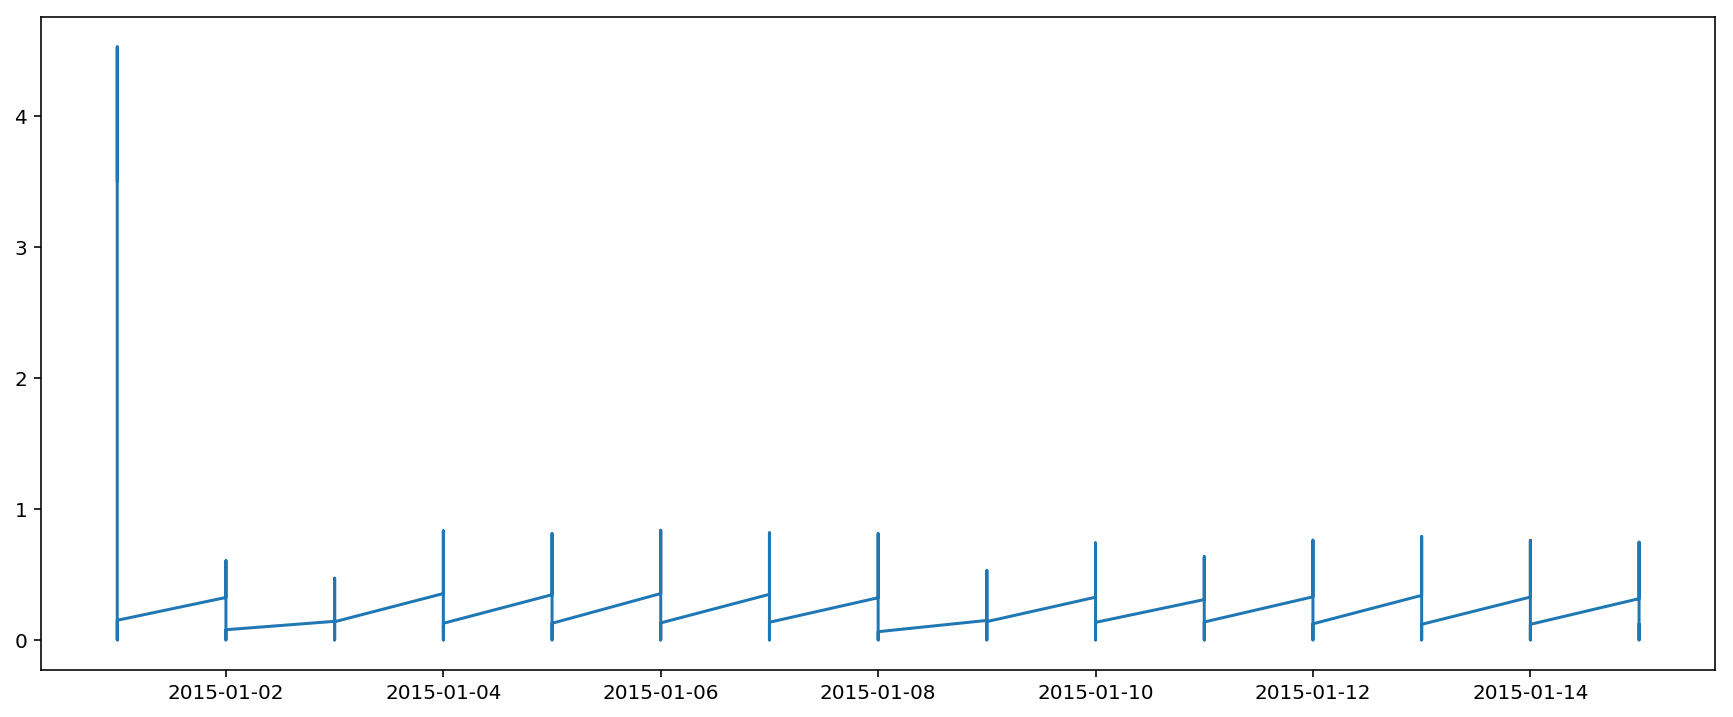

In [30]:
#line plot

plt.plot(ts['1/1/2015':'1/15/2015'])

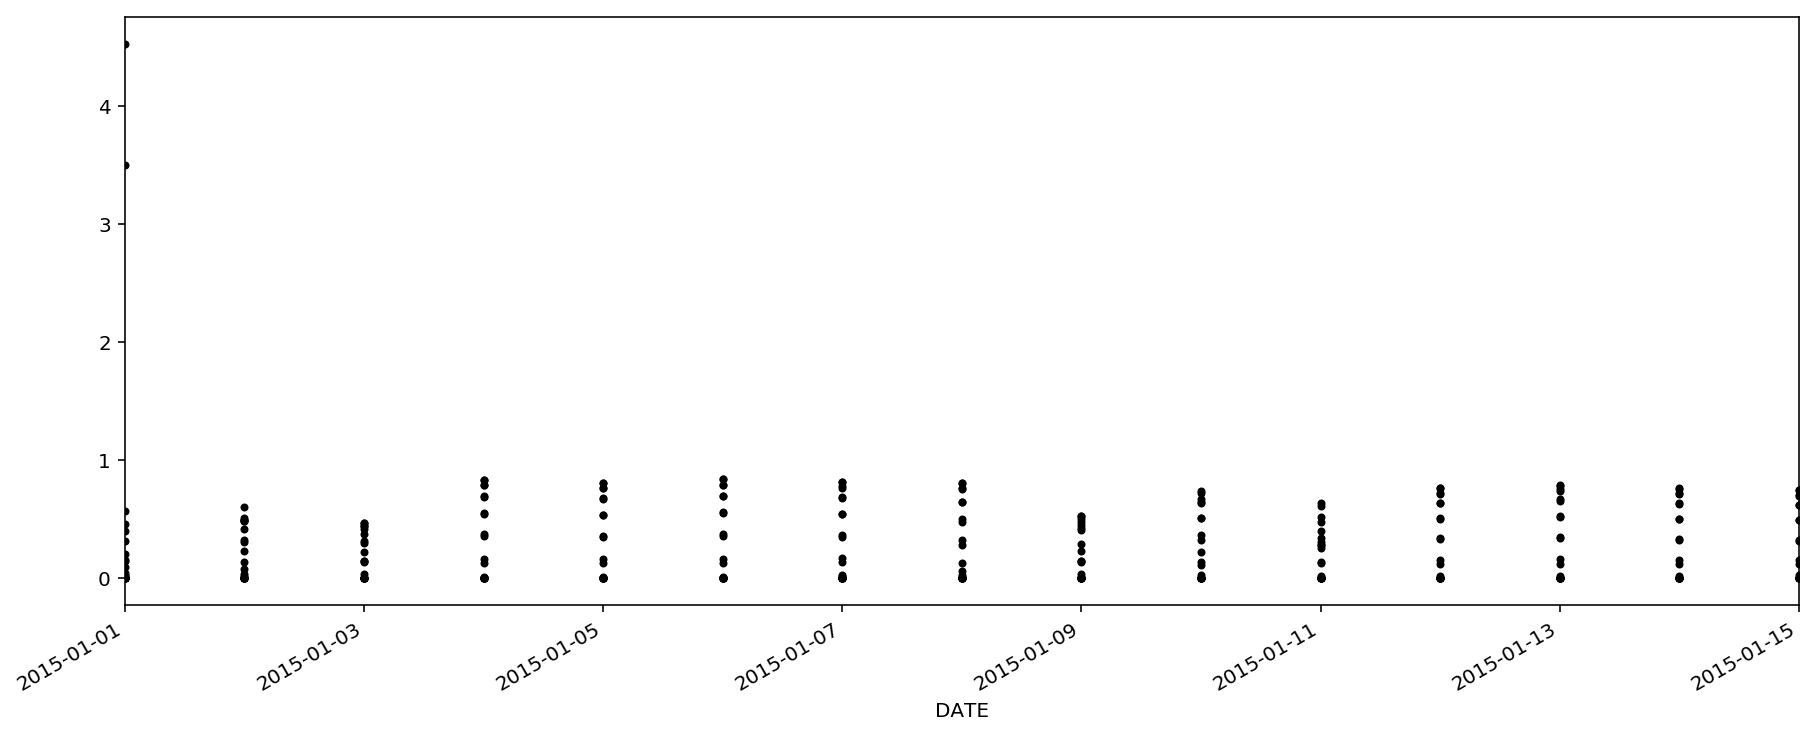

In [31]:
#black dots visualization of the data

ts['1/1/2015':'1/15/2015'].plot(style='k.')


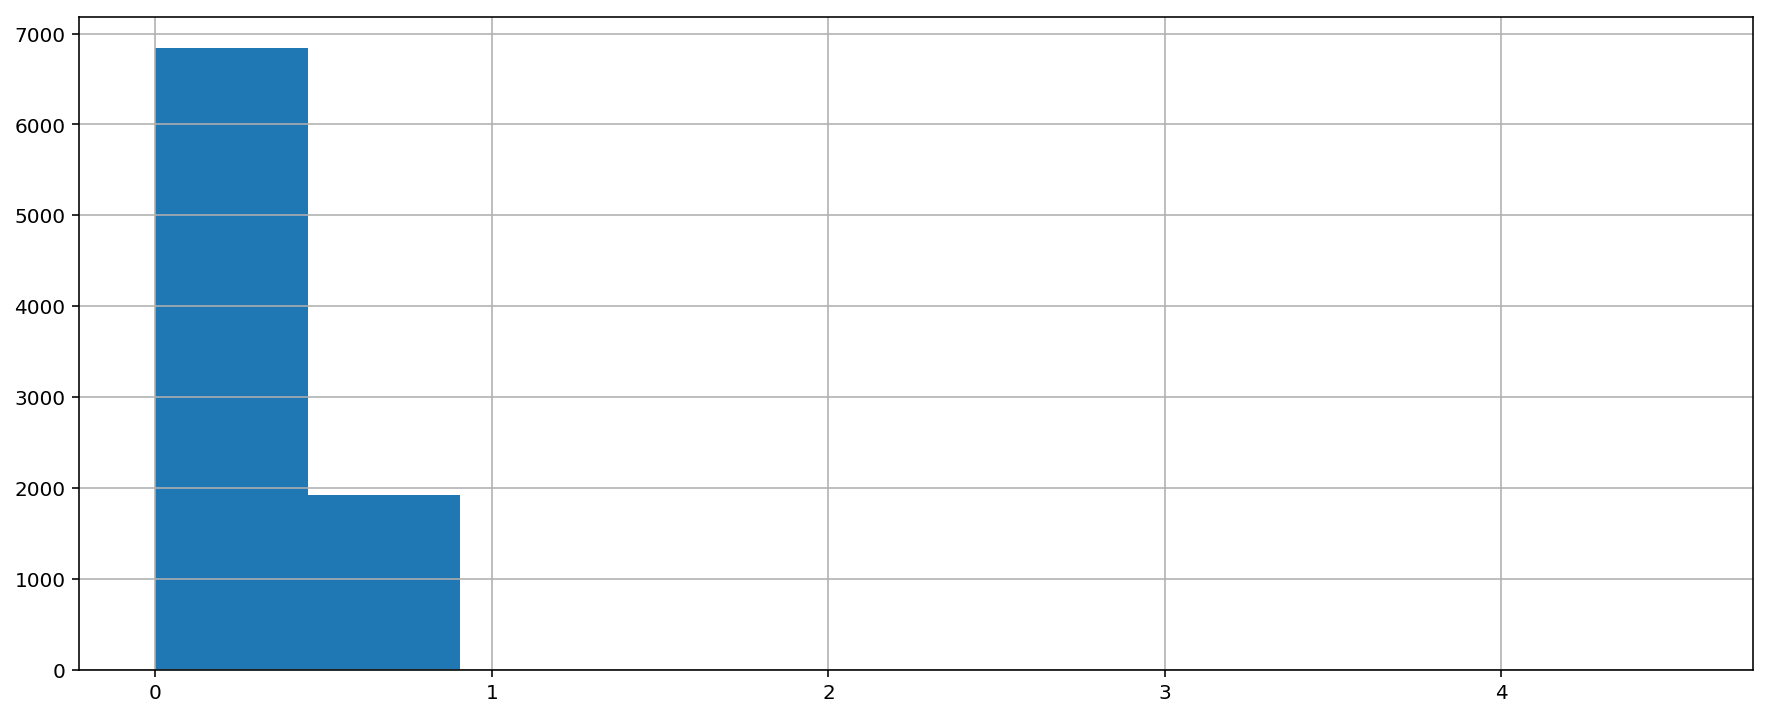

In [32]:
#histogram plot of the data

ts.hist()

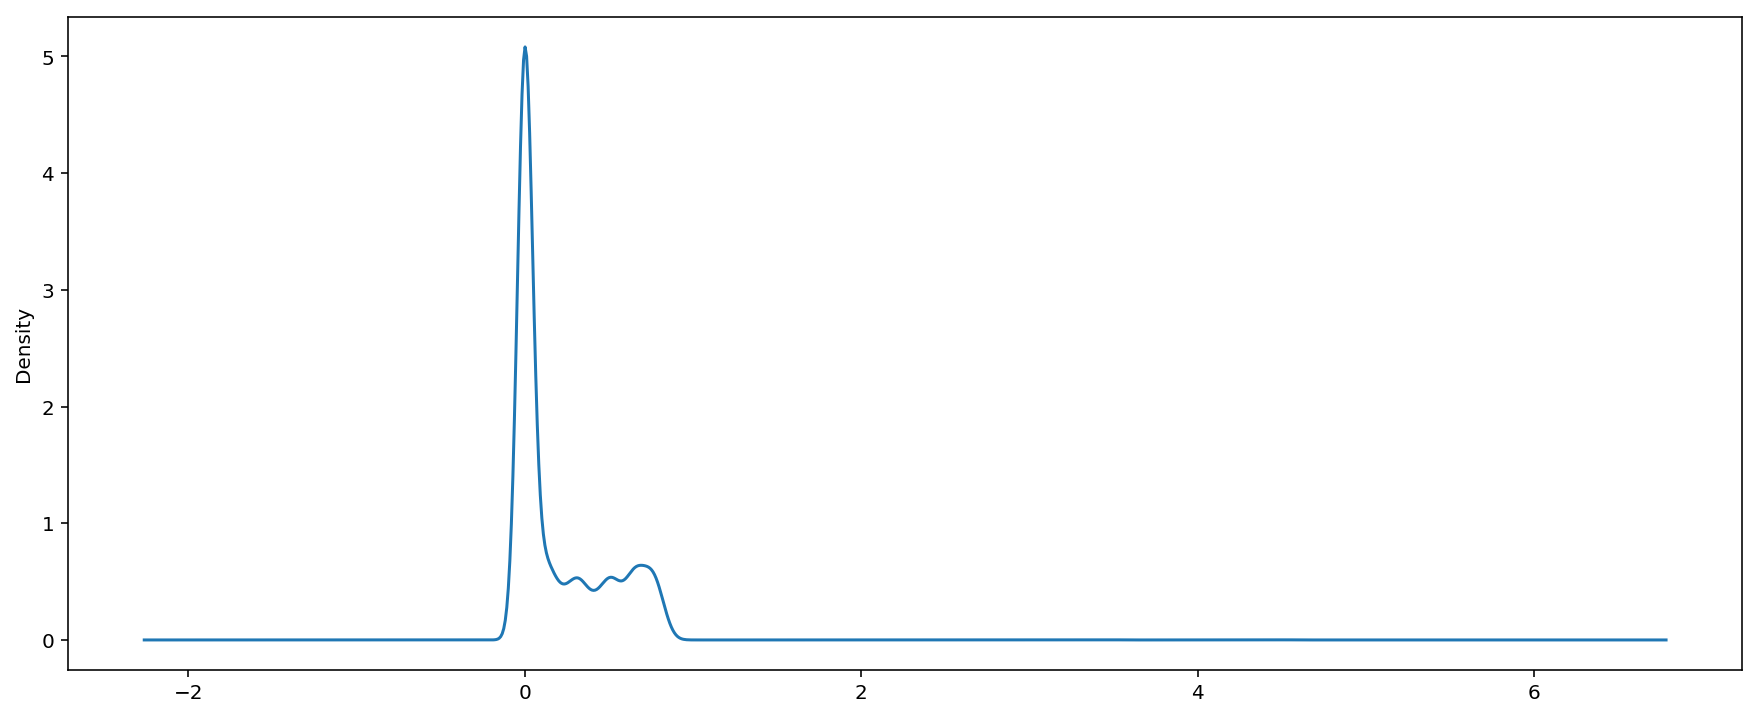

In [33]:
#smooth line used for the histogram like plot

ts.plot(kind='kde')

In [34]:
quant_features = ['Avg Relative Humidity[%]', 'Avg Specific Humidity[g/Kg]', 'Wind Speed[m/s]', 'Avg Temp[deg C]', 'Solar Power[KW]']
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
data['Solar Power[KW]'][0] = 0.803555
data['Solar Power[KW]'][1] = 0.703555

print('Normalization Successful!')

Normalization Successful!


C:\Users\arpitdec5\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\arpitdec5\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
data.head()

,HOUR,Avg Relative Humidity[%],Avg Specific Humidity[g/Kg],Wind Speed[m/s],Avg Temp[deg C],Solar Power[KW]
0,1,0.174601,-1.437976,-0.116255,0.013005,0.803555
1,2,0.125363,-1.423202,-0.146500,0.012856,0.703555
2,3,0.249236,-1.383569,-0.538386,0.012788,0.961728
3,4,0.281002,-1.354278,-0.126628,0.012540,1.355186
4,5,0.307253,-1.355916,-0.755170,0.012573,0.743141


In [36]:
#dividing data into training, validation and test data

test_data = data[-30*48:]
data = data[:-30*48]

target_fields = ['Solar Power[KW]']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
n_records = features.shape[0]
split = np.random.choice(features.index, 
                         size=int(n_records*0.7), 
                         replace=False)
train_features, train_targets = features.ix[split], targets.ix[split]
val_features, val_targets = features.drop(split), targets.drop(split)

print('Dividing data into training, validation and testing successful!')

Dividing data into training, validation and testing successful!


In [43]:
#code for rvfl network

#activation functions
def sigmoid(x):
    return 1/ (1 + np.exp(-x))

def relu(x):
    return np.maximum(x, 0, x)
    
def tanh(x):
    return np.tanh(x)

def sine(x):
    return np.sin(x)

def mape(y, Y):
    return (np.mean(np.abs(y-Y)/Y))
    
class NeuralNetwork:
    
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        
        self.learning_rate = learning_rate
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        #activation function on the outputs of hidden layer
        #self.activation_function = sigmoid
        #self.activation_function = relu
        self.activation_function = tanh
        #self.activation_function = sine
        
        #range of the random weights for input to hidden neurons
        self.weights_input_to_hidden = np.random.uniform(-0.5, 0.5,(self.hidden_nodes, self.input_nodes))
        #self.weights_input_to_hidden = np.random.uniform(0.0, 1.0,(self.hidden_nodes, self.input_nodes))
        #self.weights_input_to_hidden = np.random.uniform(-1.5, 1.5,(self.hidden_nodes, self.input_nodes))
        #self.weights_input_to_hidden = np.random.uniform(-2.0, 2.0,(self.hidden_nodes, self.input_nodes))
        
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5,(self.output_nodes, self.hidden_nodes)) 
        self.biases_output = np.random.normal(0.5, 1.0,(self.output_nodes)) 
        
    
    def train(self, inputs_list, targets_list):
        
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin = 2).T
        
        #forward pass
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) + self.biases_output
        final_outputs = final_inputs
        
        #backward pass
        output_errors = (targets - final_outputs) + (5.0 * np.sum(self.weights_hidden_to_output))/self.weights_hidden_to_output.size
        self.weights_hidden_to_output += self.learning_rate * np.dot(output_errors, hidden_outputs.T)
        self.biases_output += output_errors[0][0] * self.learning_rate
        
    def run(self, inputs_list):
        
        inputs = np.array(inputs_list, ndmin=2).T
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) + self.biases_output
        final_outputs = final_inputs
        return final_outputs

print('RWSLFN created!')

RWSLFN created!


In [44]:
#errors for analyzing the performance of our network on testing data set
def MSE(y, Y):
    return np.mean((y-Y)**2)

def RMSE(y, Y):
    return (np.mean((y-Y)**2))**0.5

def nRMSE(y, Y):
    return ((np.mean((y-Y)**2))**0.5)/np.std(Y)

In [45]:
#training the network

epochs = 1000
learning_rate = 0.00015

#varying number of hidden nodes
hidden_nodes = 15
#hidden_nodes = 15
#hidden_nodes = 20

output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, train_targets.ix[batch]['Solar Power[KW]']):
        network.train(record, target)
    if e%(epochs/10) == 0:
        
        train_loss = MSE(network.run(train_features), train_targets['Solar Power[KW]'].values)
        val_loss = MSE(network.run(val_features), val_targets['Solar Power[KW]'].values)
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        print('Training MSE loss: {:.4f}'.format(train_loss))
        print('Validation MSE loss: {:.4f}'.format(val_loss))

Training MSE loss: 0.9641
Validation MSE loss: 0.9273
Training MSE loss: 0.8332
Validation MSE loss: 0.8459
Training MSE loss: 0.6622
Validation MSE loss: 0.6863
Training MSE loss: 0.6048
Validation MSE loss: 0.6349
Training MSE loss: 0.5219
Validation MSE loss: 0.5530
Training MSE loss: 0.4963
Validation MSE loss: 0.5289
Training MSE loss: 0.4618
Validation MSE loss: 0.4940
Training MSE loss: 0.4314
Validation MSE loss: 0.4629
Training MSE loss: 0.4352
Validation MSE loss: 0.4674
Training MSE loss: 0.4196
Validation MSE loss: 0.4518


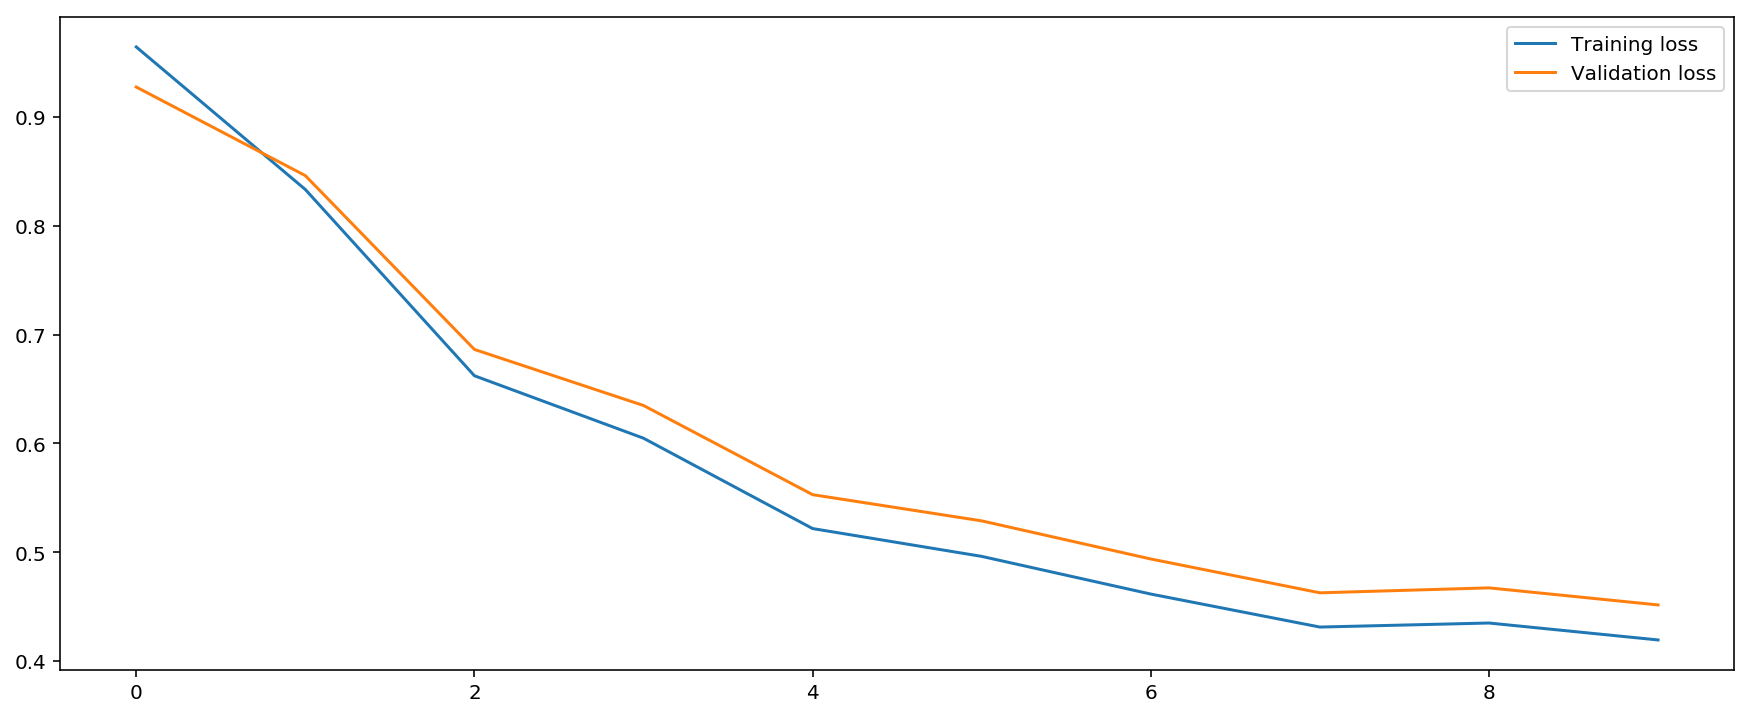

In [46]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()

In [47]:
#testing losses
print('')
print('Performance on Test Data:')
print('')
test_mse_loss = MSE(network.run(test_features), test_targets['Solar Power[KW]'].values)
print('Testing MSE loss: {:.4f}'.format(test_mse_loss))
test_rmse_loss = RMSE(test_targets['Solar Power[KW]'].values, network.run(test_features))
print('Testing RMSE loss: {:.4f}'.format(test_rmse_loss))
test_nrmse_loss = nRMSE(network.run(test_features), test_targets['Solar Power[KW]'].values)
print('Testing nRMSE loss: {:.4f}'.format(test_nrmse_loss))


Performance on Test Data:

Testing MSE loss: 0.3902
Testing RMSE loss: 0.6247
Testing nRMSE loss: 0.5927
